In [1]:
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,GRU,Bidirectional
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def getEmbeddings(embeddingdimension):
    embeddingsDict = {}
    with open("glove.6B/glove.6B." + str(embeddingdimension) + "d.txt","rt",encoding="utf-8") as embeddingsFile:
        for line in embeddingsFile:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
#             coefs = np.asarray(values[1:], dtype='float32')
            embeddingsDict[word] = coefs
    embeddingsFile.close()
    return embeddingsDict

In [3]:
def embeddingFunc(vocabSize,word_index,wordvecDimension):
    wordEmbeddingMatrix = getEmbeddings(wordvecDimension)
    embedding_matrix = np.zeros((vocabSize, wordvecDimension))
    for word, i in word_index.items():
        embedding_vector = wordEmbeddingMatrix.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [4]:
def sentimentRNN(vocabSize,word_index,wordvecDimension,learningRate,hiddenUnits,sequenceLength):
    model = Sequential()
    embedding_matrix = embeddingFunc(vocabSize,word_index,wordvecDimension)
    model.add(Embedding(vocabSize, wordvecDimension,weights = [embedding_matrix], input_length = sequenceLength, trainable = False, mask_zero =True))
    model.add(SimpleRNN(units = hiddenUnits,input_shape=[None,sequenceLength], return_sequences=False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr = learningRate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model


def sentimentLSTM(vocabSize,word_index,wordvecDimension,learningRate,hiddenUnits,sequenceLength):
    model = Sequential()
    embedding_matrix = embeddingFunc(vocabSize,word_index,wordvecDimension)
    model.add(Embedding(vocabSize, wordvecDimension,weights = [embedding_matrix], input_length = sequenceLength, trainable = False, mask_zero =True))
    model.add(LSTM(units = hiddenUnits,input_shape=[None,sequenceLength], return_sequences=False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr = learningRate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model

def sentimentBiLSTM(vocabSize,word_index,wordvecDimension,learningRate,hiddenUnits,sequenceLength):
    model = Sequential()
    embedding_matrix = embeddingFunc(vocabSize,word_index,wordvecDimension)
    model.add(Embedding(vocabSize, wordvecDimension,weights = [embedding_matrix], input_length = sequenceLength, trainable = False, mask_zero =True))
    model.add(Bidirectional(LSTM(units = hiddenUnits,input_shape=[None,sequenceLength], return_sequences=False)))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr = learningRate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model

def sentimentGRU(vocabSize,word_index,wordvecDimension,learningRate,hiddenUnits,sequenceLength):
    model = Sequential()
    embedding_matrix = embeddingFunc(vocabSize,word_index,wordvecDimension)
    model.add(Embedding(vocabSize, wordvecDimension,weights = [embedding_matrix], input_length = sequenceLength, trainable = False, mask_zero =True))
    model.add(GRU(units = hiddenUnits,input_shape=[None,sequenceLength], return_sequences=False))
    model.add(Dense(1,activation = 'sigmoid'))
    adam = tf.keras.optimizers.Adam(lr = learningRate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model

In [5]:
train_data = pd.read_csv('sentiment/train.csv')
test_data = pd.read_csv('sentiment/test.csv')

In [6]:
train_l = train_data.shape[0]
trainData = []
trainLabels = []
for i in range(train_l):
    trainData.append(train_data.iloc[i,2])
    trainLabels.append(train_data.iloc[i,1])
    
test_l = test_data.shape[0]
testData = []
testLabels = []
for i in range(test_l):
    testData.append(test_data.iloc[i,2])
    testLabels.append(test_data.iloc[i,1])

wholeData = []
wholeData.extend(trainData)
wholeData.extend(testData)



In [7]:
# wholeData,trainData,devData,testData = [],[],[],[]        #contains train,dev,test data
# wholeDataLabels, trainLabels,devLabels,testLabels = [],[],[],[]   #contains train,dev,test labels
# wholeDataIndex,trainIndex,testIndex,devIndex = [],[],[],[] 


sequenceLength = 150 # defining sequence length of 150
tokenizer = Tokenizer()
tokenizer.fit_on_texts(wholeData)
sequences = tokenizer.texts_to_sequences(wholeData)


word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen = sequenceLength)
# labels = wholeDataLabels


trainData,testData = [],[]

for i in range(0,train_l):
    trainData.append(data[i])
for i in range(train_l, test_l+train_l):
    testData.append(data[i])

vocabSize = len(word_index)+1

lstmModels = []

learningRate = 0.03
hidden_layers = [12,18,24,36]
lstmhistories = []
for i in range(4):
    lstmModels.append(sentimentGRU(vocabSize,word_index,300,learningRate,hidden_layers[i],sequenceLength))

for i in range(4):
    lstmhistories.append(lstmModels[i].fit(np.asarray(trainData), np.asarray(trainLabels), epochs=5, batch_size=150, validation_data=(np.asarray(testData), np.asarray(testLabels))))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          7725000   
_________________________________________________________________
gru (GRU)                    (None, 12)                11304     
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 7,736,317
Trainable params: 11,317
Non-trainable params: 7,725,000
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          7725000   
_________________________________________________________________
gru_1 (GRU)                  (None, 18)                17280     
______________

In [12]:
# A Function to plot the history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy']*100, label = 'Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy']*100, label = 'Val Accuracy')
    plt.ylim([50,100])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label = 'Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.ylim([0,1])
    plt.legend()


The plotting below is considering 5 Epochs
 For learning rate=12 SequenceLength = 150
 For learning rate=18 SequenceLength = 150
 For learning rate=24 SequenceLength = 150
 For learning rate=36 SequenceLength = 150


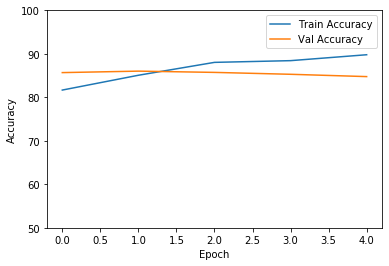

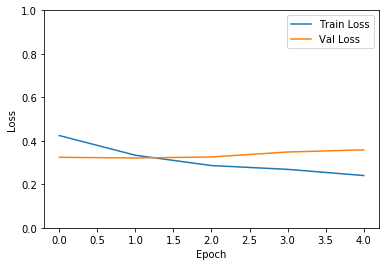

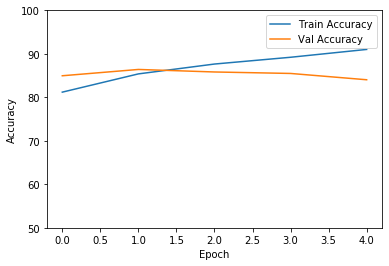

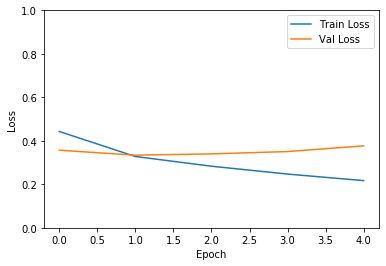

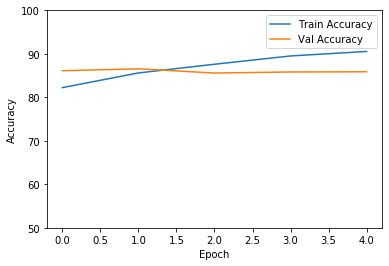

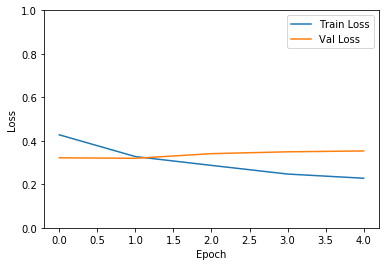

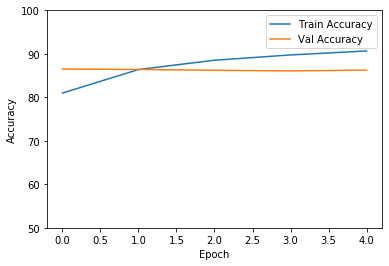

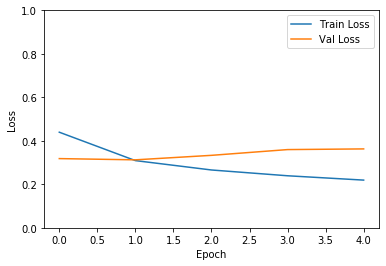

In [13]:
# Plotting the error and the accuracy for both training and validation data with epochs inorder to observe the data with best performance
print("The plotting below is considering 5 Epochs")
for i,h in enumerate(lstmhistories):
    print(" For learning rate"+"="+str(hidden_layers[i])+" SequenceLength = " + str(150))
    plot_history(h)